# Bootstrapping and Forward Rates: A Complete Tutorial

You need to price a bond. Bloomberg gives you swap rates. **Now what?**

This is the fundamental problem in fixed income: markets quote one thing (par swap rates), but you need something else (discount factors) to actually price instruments. This tutorial teaches you:

1. **Why you can't just use swap rates directly** - The translation problem
2. **How to extract discount factors** - The bootstrapping algorithm
3. **How to derive forward rates** - What the curve tells us about future rates

**Prerequisites:** Basic Python, basic algebra. No prior finance knowledge required.

---

## Table of Contents

**Part I: The Problem**
1. Why Can't We Just Use Swap Rates?
2. The Language of Discounting

**Part II: The Solution — Bootstrapping**
3. Where Par Rates Come From
4. The Bootstrapping Algorithm
5. Verify Your Understanding

**Part III: The Payoff — Forward Rates**
6. What the Curve Tells Us About Future Rates
7. The Complete Picture

**Part IV: Working with Real Data**
8. Implementation with Bloomberg

---

## Part I: The Problem

---

## 1. Why Can't We Just Use Swap Rates?

### 1.1 A Concrete Problem: Pricing a Simple Bond

Suppose you need to price a bond that pays:
- `$100` in 1 year
- `$100` in 2 years
- `$1,100` in 3 years (final coupon + principal)

You open Bloomberg and see today's swap rates:

<table align="left">
<tr><th>Tenor</th><th>Swap Rate</th></tr>
<tr><td>1 Year</td><td>3.40%</td></tr>
<tr><td>2 Year</td><td>3.28%</td></tr>
<tr><td>3 Year</td><td>3.30%</td></tr>
</table>
<div style="clear: both;"></div>

**The question:** Can you use these rates to discount the cash flows?

You might try:

$$PV = \frac{\$100}{1.034} + \frac{\$100}{1.0328^2} + \frac{\$1100}{1.033^3} = \text{???}$$

**This is wrong.** The answer you get won't match Bloomberg's pricing. Why not?

### 1.2 What Markets Actually Quote

Here's the key insight: **markets don't quote discount factors directly**. They quote *par swap rates*.

A **par swap rate** is the fixed rate that makes a swap worth exactly `$0` at inception. It's a very specific number that depends on *all* the discount factors from year 1 through the maturity.

Think about what the 3-year swap rate of 3.30% actually represents:
- It's the rate where paying 3.30% fixed for 3 years is "fair" compared to receiving floating
- It reflects an *average* of the term structure, weighted by when cash flows occur
- It is NOT the "3-year zero rate" - it's something more complicated

> **⚠️ Bloomberg:** Tickers like `USSO10 Curncy` quote **par swap rates**, not zero rates. Even screens labeled "yield curve" often show par rates unless you specifically select a different rate type.

### 1.3 The Translation Gap

The problem is a **translation gap**: markets give us one thing (par swap rates), but to price instruments, we need something else (discount factors).

<table align="left">
<tr><th>What We Have</th><th>What We Need</th></tr>
<tr><td>Par swap rates (market quotes)</td><td>Discount factors (for pricing)</td></tr>
<tr><td>3.40%, 3.28%, 3.30%...</td><td>0.967, 0.937, 0.906...</td></tr>
</table>
<div style="clear: both;"></div>

**Why can't we just convert directly?**

If there were a single interest rate $r$ for all maturities, we could use:

$$DF(T) = \frac{1}{(1+r)^T}$$

But there isn't one rate - there's a whole curve of rates! And the par swap rates we observe are *derived from* the discount factors, not the other way around. They're already "baked" with information about the entire curve.

To get discount factors from par swap rates, we need to *invert* the relationship. This is what **bootstrapping** does.

### 1.4 What We'll Build

This tutorial teaches you to solve the translation problem:

**Step 1: Understand the inputs** (Sections 2-3)
- What discount factors actually are
- How par swap rates relate to discount factors
- Where the market data comes from

**Step 2: Extract discount factors** (Sections 4-5)
- The bootstrapping algorithm
- Worked examples you can do by hand

**Step 3: Derive forward rates** (Sections 6-7)
- What the curve tells us about future rates
- The no-arbitrage relationship
- The complete picture

**Step 4: Work with real data** (Section 8)
- Fetching Bloomberg data
- Full implementation
- Validation

By the end, you'll be able to take market quotes and produce a full discount curve - the foundation for pricing any fixed income instrument.

---

## 2. The Language of Discounting

Before we solve the translation problem, we need to understand what we're translating FROM and TO.

### 2.1 Discount Factors: The Universal Translator

A **discount factor** answers: *"What is `$1` received at time T worth today?"*

If the 1-year interest rate is 5%:
- `$1` today grows to `$1.05` in 1 year
- `$1` in 1 year is worth `$1` ÷ 1.05 = `$0.9524` today

The discount factor for 1 year is **0.9524**.

**Key properties of discount factors:**
- Always between 0 and 1 (future money worth less than today's)
- Decrease with time (more distant = less valuable)
- $DF(0) = 1$ exactly (money today is worth full value)

**Why discount factors are "universal":** Every fixed income calculation - bond pricing, swap valuation, derivatives - ultimately reduces to multiplying cash flows by discount factors:

$$PV = \sum_{t} \text{Cash Flow}_t \times DF_t$$

### 2.2 The Two Rate Types You Must Know

This is the critical distinction that confuses many practitioners. There are two fundamentally different ways to quote interest rates:

---

**Par Rate = Swap Rate** (What Markets Quote)

These terms are interchangeable:
- The fixed rate that makes a swap worth `$0` at inception
- Reflects a *weighted average* across all coupon periods
- What Bloomberg quotes (USSO* tickers)
- What you see on trading screens

When someone says "the 10-year swap rate is 3.75%," they mean the 10-year **par rate**.

---

**Spot Rate = Zero Rate** (What Bootstrapping Produces)

These terms are interchangeable. You'll hear both in practice:
- **"Spot rate"** — emphasizes *today's* rate for that maturity (the "spot" price of money)
- **"Zero rate"** — emphasizes it's the yield on a *zero-coupon* bond

Both mean exactly the same thing:
- The rate for a single cash flow at maturity
- The "pure" rate for that specific tenor, with no coupon averaging
- Relationship to discount factors: $DF(T) = \frac{1}{(1 + z_T)^T}$

**Bootstrapping produces spot/zero rates.** Starting from par swap rates, the algorithm extracts the spot (zero) rate for each maturity.

---

**Example with numbers:**

<table align="left">
<tr><th>Tenor</th><th>Par Rate (= Swap Rate)</th><th>Spot Rate (= Zero Rate)</th><th>Difference</th></tr>
<tr><td>1Y</td><td>3.40%</td><td>3.45%</td><td>+5 bp</td></tr>
<tr><td>5Y</td><td>3.42%</td><td>3.47%</td><td>+5 bp</td></tr>
<tr><td>10Y</td><td>3.75%</td><td>3.84%</td><td>+9 bp</td></tr>
<tr><td>30Y</td><td>4.11%</td><td>4.24%</td><td>+13 bp</td></tr>
</table>
<div style="clear: both;"></div>

Notice: **Spot rates are higher than par rates** (for upward-sloping curves). The gap widens with tenor.

> **⚠️ Bloomberg:** In Terminal, the default "Rate Type" is often par. To see spot/zero rates: `YCSW0490 Index CRVF <GO>` → Rate Type dropdown → select "Zero Rate".

### 2.3 Why Par and Spot Rates Differ

Think about a 3-year par swap paying 3.30% annually.

The swap has cash flows at years 1, 2, and 3:
- Year 1 coupon is discounted at the 1-year rate
- Year 2 coupon is discounted at the 2-year rate
- Year 3 coupon is discounted at the 3-year rate

The 3.30% par rate is a **weighted average** of these different rates, where earlier periods (with higher discount factors) get more weight.

The 3-year spot rate, in contrast, is the **pure** rate for a single cash flow at year 3 - no averaging.

**Analogy:** 
- Par rate = average speed for a road trip (includes stop signs and highways)
- Spot rate = instantaneous speedometer reading at the destination

### 2.4 The Mathematical Fingerprint

The relationship between par and spot rates provides a reliable "fingerprint":

**For an upward-sloping curve:**
$$\text{Spot Rate} > \text{Par Rate} \quad \text{(at the same tenor)}$$

**The gap pattern:**
- Small at short tenors (~1-2 bp at 2Y)
- Larger at long tenors (~15-25 bp at 30Y)

**Why?** When the curve slopes upward, later coupons are discounted at higher rates. This "pulls down" the par rate relative to the pure spot rate. The effect accumulates with tenor.

**The test:** If you're given rate data and need to identify whether it's par or spot:
1. Bootstrap from the par rates
2. Compare bootstrapped spot rates to the original data
3. If they match → you have spot rates
4. If spot rates are higher → you had par rates

This test will be demonstrated in Section 5.

**Special Case: The Flat Curve**

When the yield curve is flat (same rate at all maturities), something elegant happens:

$$\text{Par Rate} = \text{Spot Rate} = \text{Forward Rate}$$

Why? If every maturity has the same rate $r$:
- Spot rate at any tenor is just $r$
- Par rate is the weighted average of identical rates = $r$
- Forward rate between any two periods is $r$ (no slope to amplify)

This is why academic papers often assume flat curves for simplicity: *"The risk-free yield curve is assumed to be flat at 5%, so the forward curve is also flat at 5%."*

---

## Part II: The Solution — Bootstrapping

---

## 3. Where Par Rates Come From

Now that we understand what we need (discount factors) and what we have (par swap rates), let's understand the input data better.

### 3.1 What Is an Interest Rate Swap?

An **interest rate swap** is a contract to exchange interest payments:

```
    ┌─────────────────┐                    ┌─────────────────┐
    │    Party A      │                    │    Party B      │
    │  (pays fixed)   │                    │ (pays floating) │
    └────────┬────────┘                    └────────┬────────┘
             │                                      │
             │         pays 4% fixed rate           │
             ├─────────────────────────────────────→│
             │                                      │
             │       pays SOFR (floating rate)      │
             │←─────────────────────────────────────┤
```

**Example:** A 5-year swap on `$1 million` notional with 4% fixed rate:
- Party A pays: 4% × `$1,000,000` = `$40,000` per year (fixed, known in advance)
- Party B pays: SOFR rate × `$1,000,000` per year (floating, changes daily)

**Why do swaps exist?**
- Banks manage interest rate risk
- Companies convert floating debt to fixed (or vice versa)
- Investors speculate on rate movements

### 3.2 The Par Swap Rate

The **par swap rate** is the fixed rate that makes the swap worth exactly `$0` at inception.

Think about it: if you're entering a swap, and neither side has to pay anything upfront, then the fixed rate must be "fair" - the expected values of both legs are equal.

This is crucial: **the par rate encodes information about all future discount factors**, because the PV of the fixed leg must equal the PV of the floating leg.

### 3.3 OIS: The Modern Discounting Standard

An **OIS (Overnight Index Swap)** is a swap where the floating leg pays a daily overnight rate:

**SOFR** (Secured Overnight Financing Rate):
- Based on overnight repo market transactions
- Considered "risk-free" (overnight, collateralized)
- Replaced LIBOR in 2023 as the USD benchmark

> **⚠️ Bloomberg:** Post-LIBOR transition (June 2023), SOFR is the standard USD discounting curve. Legacy LIBOR-based curves still exist in historical data but should not be used for new analysis.

### 3.4 What Bloomberg Quotes

Bloomberg provides OIS par swap rates via the USSO* tickers:

<table align="left">
<tr><th>Ticker</th><th>Description</th></tr>
<tr><td><code>USSO1 Curncy</code></td><td>1-year USD SOFR OIS par rate</td></tr>
<tr><td><code>USSO5 Curncy</code></td><td>5-year USD SOFR OIS par rate</td></tr>
<tr><td><code>USSO10 Curncy</code></td><td>10-year USD SOFR OIS par rate</td></tr>
<tr><td><code>USSO30 Curncy</code></td><td>30-year USD SOFR OIS par rate</td></tr>
</table>
<div style="clear: both;"></div>

**Important:** These are **par swap rates** (curve inputs), NOT zero rates or discount factors (curve outputs).

The values you see (e.g., 3.75% for USSO10) are the "fair" fixed rates for entering a swap today. To get discount factors or zero rates, you must bootstrap.

---

## 4. The Bootstrapping Algorithm

### 4.1 The Key Insight

Remember: a par swap is worth `$0` at inception. This means:

**Present Value of Fixed Leg = Present Value of Floating Leg**

For a par swap, the floating leg's present value equals the notional (we'll take this as given). So:

**Present Value of Fixed Leg = Notional (which we set to `$1`)**

This equation lets us solve for discount factors!

### 4.2 Bootstrapping Year 1

Let's work through swaps of increasing maturity. We'll use:
- `$1` notional (to keep math simple)
- $r_1, r_2, r_3...$ = par swap rates for 1-year, 2-year, 3-year swaps
- $DF_1, DF_2, DF_3...$ = discount factors we want to find
- Day count = 365/360 (market convention for USD swaps)

A 1-year swap has one cash flow at year 1: you pay the fixed rate plus return the notional.

Cash flows for 1-year swap:
- Year 1: Pay $(r_1 \times \text{notional}) + \text{notional} = (1 + r_1) \times \$1$

Present value equation (must equal `$1` for par swap):

$\displaystyle DF_1 \times (1 + r_1) = 1$

Solving for $DF_1$:

$$DF_1 = \frac{1}{1 + r_1}$$

**Example:** If $r_1 = 3.4\%$, then $DF_1 = 1 / 1.034 = 0.9671$

### 4.3 Bootstrapping Year 2

A 2-year swap has TWO cash flows:
- Year 1: Pay $r_2$ (just the coupon)
- Year 2: Pay $r_2 + 1$ (coupon plus notional)

Present value equation:

$\displaystyle DF_1 \times r_2 + DF_2 \times (1 + r_2) = 1$

We already know $DF_1$ from the 1-year swap! Solve for $DF_2$:

$$DF_2 = \frac{1 - DF_1 \times r_2}{1 + r_2}$$

### 4.4 The General Formula

For an N-year swap:

$$DF_n = \frac{1 - r_n \times \sum_{i=1}^{n-1} DF_i}{1 + r_n}$$

This is called **bootstrapping** because we:
1. Start with the 1-year swap to get $DF_1$
2. Use $DF_1$ to calculate $DF_2$ from the 2-year swap
3. Use $DF_1$ and $DF_2$ to calculate $DF_3$ from the 3-year swap
4. Continue "pulling ourselves up by our bootstraps"

Each step builds on the previous ones!

*This is an implementation of the forward substitution algorithm from [Wikipedia: Bootstrapping (finance)](https://en.wikipedia.org/wiki/Bootstrapping_%28finance%29).*

### 4.5 Day Count: The 365/360 Factor

In real markets, we need to account for exactly how many days are in each period. The **day count convention** specifies how to calculate the fraction of a year.

For USD OIS swaps, the convention is **ACT/360**:
- Count the actual number of days in the period
- Divide by 360 (not 365!)

For annual payments, this means roughly $\frac{365}{360} \approx 1.0139$

So our formulas become:

$$DF_1 = \frac{1}{1 + r_1 \times \frac{365}{360}}$$

$$DF_n = \frac{1 - r_n \times \frac{365}{360} \times \sum_{i=1}^{n-1} DF_i}{1 + r_n \times \frac{365}{360}}$$

> **⚠️ Bloomberg:** USD OIS uses ACT/360 day count. This ~1.4% adjustment is small but essential for matching real market calculations. Bloomberg's bootstrap may use slightly different conventions for different curve types.

---

## 5. Verify Your Understanding: Manual Calculations

Before running any code, let's verify we understand the algorithm with pencil-and-paper calculations.

### 5.1 Sample Data

Using today's approximate par swap rates:

<table align="left">
<tr><th>Tenor</th><th>Par Swap Rate</th></tr>
<tr><td>1 Year</td><td>3.40%</td></tr>
<tr><td>2 Year</td><td>3.28%</td></tr>
<tr><td>3 Year</td><td>3.30%</td></tr>
</table>
<div style="clear: both;"></div>

### 5.2 Step-by-Step Calculation

**Step 1: Calculate $DF_1$**

$$DF_1 = \frac{1}{1 + r_1 \times \frac{365}{360}} = \frac{1}{1 + 0.034 \times 1.0139} = \frac{1}{1.0345} = 0.9667$$

**Step 2: Calculate $DF_2$**

$$DF_2 = \frac{1 - r_2 \times \frac{365}{360} \times DF_1}{1 + r_2 \times \frac{365}{360}}$$

$$= \frac{1 - 0.0328 \times 1.0139 \times 0.9667}{1 + 0.0328 \times 1.0139}$$

$$= \frac{1 - 0.0322}{1.0333} = \frac{0.9678}{1.0333} = 0.9366$$

**Step 3: Calculate $DF_3$**

$$DF_3 = \frac{1 - r_3 \times \frac{365}{360} \times (DF_1 + DF_2)}{1 + r_3 \times \frac{365}{360}}$$

$$= \frac{1 - 0.033 \times 1.0139 \times (0.9667 + 0.9366)}{1 + 0.033 \times 1.0139}$$

$$= \frac{1 - 0.0637}{1.0335} = \frac{0.9363}{1.0335} = 0.9059$$

### 5.3 Convert to Zero Rates

From discount factors, we can calculate zero rates:

$$z_T = \left(\frac{1}{DF_T}\right)^{1/T} - 1$$

<table align="left">
<tr><th>Tenor</th><th>Discount Factor</th><th>Zero Rate</th></tr>
<tr><td>1Y</td><td>0.9667</td><td>3.45%</td></tr>
<tr><td>2Y</td><td>0.9366</td><td>3.32%</td></tr>
<tr><td>3Y</td><td>0.9059</td><td>3.35%</td></tr>
</table>
<div style="clear: both;"></div>

### 5.4 Sanity Checks

Always verify your bootstrapped results:

**✓ Discount factors in (0, 1):** 0.97, 0.94, 0.91 - all valid

**✓ Discount factors decreasing:** 0.97 > 0.94 > 0.91 - correct

**✓ Zero rate > Par rate:** For our upward-sloping sections:
- 1Y: Zero 3.45% > Par 3.40% ✓
- 3Y: Zero 3.35% > Par 3.30% ✓

**✓ Consistency check:** $DF = 1/(1+z)^T$
- Year 1: $1/(1.0345)^1 = 0.9667$ ✓
- Year 3: $1/(1.0335)^3 = 0.9058$ ✓

If any check fails, review your calculations.

---

## Part III: The Payoff — Forward Rates

---

## 6. What the Curve Tells Us About Future Rates

We've learned to extract discount factors and zero rates from par swap rates. Now for the payoff: **forward rates** - what the curve tells us about future interest rates.

### 6.1 The Question Forward Rates Answer

A **forward rate** answers questions like:
- *"What 1-year rate does the market imply for a loan starting in 2 years?"* (the "2y1y forward")
- *"What overnight rate is implied for 5 years from now?"*

Forward rates are **not predictions** - they're mathematical consequences of today's zero rates. They represent the rate at which you could lock in borrowing/lending for a future period using today's instruments.

### 6.2 The No-Arbitrage Argument

The key insight is **no-arbitrage**: investing for 3 years at the 3-year zero rate must equal investing for 2 years at the 2-year rate, then reinvesting for 1 year at the (implied) forward rate.

$$(1 + z_2)^2 \times (1 + f_{2,3}) = (1 + z_3)^3$$

Where:
- $z_2$ = 2-year zero rate
- $z_3$ = 3-year zero rate  
- $f_{2,3}$ = 1-year forward rate starting at year 2

**Why must this hold?** If it didn't, you could profit risk-free by borrowing at one rate and lending at another. Arbitrageurs would quickly trade away the difference.

### 6.3 The Forward Rate Formulas

Solving for the forward rate:

$$f_{t_1, t_2} = \left( \frac{(1 + z_{t_2})^{t_2}}{(1 + z_{t_1})^{t_1}} \right)^{\frac{1}{t_2 - t_1}} - 1$$

Or equivalently using discount factors:

$$f_{t_1, t_2} = \left( \frac{DF_{t_1}}{DF_{t_2}} \right)^{\frac{1}{t_2 - t_1}} - 1$$

Both formulas give the same answer - use whichever is more convenient.

### 6.4 Worked Example: The 2y1y Forward

Let's calculate the 1-year forward rate starting in 2 years.

**Given** (from our bootstrapped curve):
- $z_2$ = 3.32% (2-year zero rate)
- $z_3$ = 3.35% (3-year zero rate)

**Step 1:** Calculate growth factors
- $(1 + z_3)^3 = (1.0335)^3 = 1.1039$
- $(1 + z_2)^2 = (1.0332)^2 = 1.0675$

**Step 2:** Find implied 1-year growth from year 2 to 3
- $(1 + f_{2,3}) = \frac{1.1039}{1.0675} = 1.0341$

**Step 3:** Extract forward rate
- $f_{2,3} = 1.0341 - 1 = 0.0341 = 3.41\%$

**Interpretation:** The 2y1y forward rate is 3.41%. This means:
- You could lock in today a 1-year loan starting 2 years from now at 3.41%
- This rate is *higher* than both the 2Y and 3Y zero rates (characteristic of upward-sloping curves)

### 6.5 Interpreting Forward Rates

**Forward rates are "marginal" rates:** They represent the incremental rate for extending the loan one more period. For an upward-sloping curve, they're higher than the corresponding zero rates.

**Forward rates amplify the curve slope:** A small upward slope in zero rates becomes a larger slope in forward rates. This makes forwards useful for:
- Detecting market expectations about rate changes
- Pricing Forward Rate Agreements (FRAs)
- Understanding the "term premium" embedded in longer rates

> **⚠️ Bloomberg:** Forward curve functions (e.g., `FWCV`) are available in Terminal. Be aware that forwards are highly sensitive to interpolation methodology - small differences in the zero curve can produce larger differences in forwards.

---

## 7. The Complete Picture

### 7.1 The Data Flow

We've traced the complete transformation:

```
Par Swap Rates (Market Quotes)
         │
         ▼ Bootstrapping
   ┌─────┴─────┐
   │           │
   ▼           ▼
Discount    Zero Rates
Factors
   │           │
   └─────┬─────┘
         │
         ▼ No-Arbitrage
   Forward Rates
```

### 7.2 When to Use Each Form

<table align="left">
<tr><th>Data Type</th><th>What It Represents</th><th>When to Use</th></tr>
<tr><td><b>Par Swap Rates</b></td><td>Market-quoted "fair" fixed rates</td><td>Trading, quoting, hedging with swaps</td></tr>
<tr><td><b>Discount Factors</b></td><td>PV of `$1` at each maturity</td><td>Pricing bonds, valuing swap legs</td></tr>
<tr><td><b>Zero Rates</b></td><td>Pure yield for zero-coupon bonds</td><td>Comparing across maturities, reporting</td></tr>
<tr><td><b>Forward Rates</b></td><td>Implied future short-term rates</td><td>FRAs, futures, expectations analysis</td></tr>
</table>
<div style="clear: both;"></div>

### 7.3 The Key Insight

**All four representations contain the same information.** They're mathematically equivalent views of the term structure:

$$\text{Par Rates} \leftrightarrow \text{Discount Factors} \leftrightarrow \text{Zero Rates} \leftrightarrow \text{Forward Rates}$$

Given any one, you can derive all the others. The choice depends on what's most convenient for your application.

### 7.4 Practical Applications

**Price a bond:** Multiply each cash flow by its discount factor and sum:
$$PV = \sum_t CF_t \times DF_t$$

**Value an existing swap:** Compare the PV of fixed leg vs floating leg. A swap worth `$0` at inception may be worth ± millions later.

**Price a Forward Rate Agreement (FRA):** Use forward rates directly - an FRA locks in a future borrowing rate.

**Measure interest rate risk (DV01):** Shift the curve by 1bp, re-bootstrap, and see how portfolio value changes.

> **⚠️ Bloomberg:** The BQL function `curvemembers('YCSW0490 Index')` returns curve **inputs** (par swap rates), not outputs. To get bootstrapped zero rates or discount factors, you must either bootstrap yourself or access Bloomberg's pre-computed curves with appropriate licensing.

**A Note on Terminology**

When practitioners say "priced off the forward curve," they usually mean discounting using the curve's discount factors—not applying forward rates directly.

**What's actually used for discounting:** Discount factors.

$$PV = \sum_t CF_t \times DF_t$$

**What forward rates are used for:**
- Projecting future floating rate payments (e.g., "What will SOFR be in 2 years?")
- Pricing Forward Rate Agreements (FRAs)
- The instantaneous rate $r(t)$ in continuous-time PDEs

The phrase "forward curve" is often loose jargon for "the yield curve" in general. All four representations (par, DF, zero, forward) contain the same information—practitioners just pick the most convenient form for their task.

### 7.5 Risk-Free vs. Risky Curves

The OIS curve we bootstrapped is considered **risk-free** (overnight, collateralized). But what if you need to price cash flows from an issuer who might default?

**Building a Risky Curve**

A **risky curve** adds a credit spread to the risk-free curve:

$$z^{\text{risky}}_T = z^{\text{risk-free}}_T + s_T$$

Where $s_T$ is the credit spread at tenor $T$ (from CDS markets or bond spreads).

Then derive risky discount factors:

$$DF^{\text{risky}}_T = \frac{1}{(1 + z^{\text{risky}}_T)^T}$$

**Key insight:** The formulas are identical. "Risky" just means different input rates—the bootstrapping math doesn't change.

**When to use which:**
- **Risk-free curve:** Discount collateralized cash flows, derivative valuations
- **Risky curve:** Discount cash flows subject to issuer default (corporate bonds, loans)

### 7.6 Compounding Conventions

Our tutorial uses **annual compounding**:

$$DF_T = \frac{1}{(1 + z_T)^T}$$

Many academic papers and PDE-based models use **continuous compounding**:

$$DF_T = e^{-z_T \cdot T}$$

**Converting between conventions:**

Given an annually compounded rate $z_{\text{ann}}$, the equivalent continuously compounded rate is:

$$z_{\text{cont}} = \ln(1 + z_{\text{ann}})$$

And vice versa:

$$z_{\text{ann}} = e^{z_{\text{cont}}} - 1$$

**Why it matters:** When you see "the risk-free rate is 5% with continuous compounding," this means $z_{\text{cont}} = 0.05$, so $DF_1 = e^{-0.05} = 0.9512$. With annual compounding at 5%, $DF_1 = 1/1.05 = 0.9524$.

In [1]:
# Worked Example: Building a Risky Curve
# Suppose our 2Y and 5Y zero rates are 4.5% and 4.8%, and the issuer's credit spread is 200bp flat

credit_spread = 0.02  # 200 basis points

# Risk-free zero rates (from our bootstrap)
z_rf_2y = 0.045
z_rf_5y = 0.048

# Risky zero rates = risk-free + spread
z_risky_2y = z_rf_2y + credit_spread  # 6.5%
z_risky_5y = z_rf_5y + credit_spread  # 6.8%

# Risky discount factors (annual compounding)
df_risky_2y = 1 / (1 + z_risky_2y)**2
df_risky_5y = 1 / (1 + z_risky_5y)**5

print("Risky Curve Example (200bp credit spread)")
print("=" * 50)
print(f"2Y: z_rf={z_rf_2y:.2%} → z_risky={z_risky_2y:.2%} → DF_risky={df_risky_2y:.6f}")
print(f"5Y: z_rf={z_rf_5y:.2%} → z_risky={z_risky_5y:.2%} → DF_risky={df_risky_5y:.6f}")

Risky Curve Example (200bp credit spread)
2Y: z_rf=4.50% → z_risky=6.50% → DF_risky=0.881659
5Y: z_rf=4.80% → z_risky=6.80% → DF_risky=0.719687


In [2]:
# Compounding Convention Conversion
import numpy as np

z_annual = 0.05  # 5% annually compounded

# Convert to continuous
z_continuous = np.log(1 + z_annual)

# Verify: both give same DF
df_from_annual = 1 / (1 + z_annual)
df_from_continuous = np.exp(-z_continuous)

print("Compounding Convention Conversion")
print("=" * 50)
print(f"Annual rate:                {z_annual:.4%}")
print(f"Equivalent continuous rate: {z_continuous:.4%}")
print(f"1Y DF (annual):             {df_from_annual:.6f}")
print(f"1Y DF (continuous):         {df_from_continuous:.6f}")

Compounding Convention Conversion
Annual rate:                5.0000%
Equivalent continuous rate: 4.8790%
1Y DF (annual):             0.952381
1Y DF (continuous):         0.952381


---

## Part IV: Working with Real Data

---

## 8. Implementation with Bloomberg

Now let's implement everything we've learned using real market data from Bloomberg.

### 8.1 Fetching OIS Rates

Bloomberg provides USD SOFR OIS par swap rates via the `USSO*` tickers:

<table align="left">
<tr><th>Ticker</th><th>Description</th></tr>
<tr><td><code>USSO1 Curncy</code></td><td>1-year USD SOFR OIS rate</td></tr>
<tr><td><code>USSO2 Curncy</code></td><td>2-year USD SOFR OIS rate</td></tr>
<tr><td><code>...</code></td><td>...</td></tr>
<tr><td><code>USSO30 Curncy</code></td><td>30-year USD SOFR OIS rate</td></tr>
</table>
<div style="clear: both;"></div>

> **⚠️ Bloomberg:** Not all tenors are quoted. Bloomberg provides 1-12, 15, 20, 25, 30 years. Missing tenors (13, 14, 16-19, etc.) must be interpolated.

In [3]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from blp import Blp
from date import Date

today = Date.today()
print(f"Today: {today}")

Today: 2026-01-08


Bloomberg uses ticker symbols to identify securities. For USD SOFR OIS rates:

<table align="left">
<tr><th>Ticker</th><th>Meaning</th></tr>
<tr><td><code>USSO1 Curncy</code></td><td>1-year USD SOFR OIS rate</td></tr>
<tr><td><code>USSO2 Curncy</code></td><td>2-year USD SOFR OIS rate</td></tr>
<tr><td><code>USSO10 Curncy</code></td><td>10-year USD SOFR OIS rate</td></tr>
<tr><td><code>USSO30 Curncy</code></td><td>30-year USD SOFR OIS rate</td></tr>
</table>
<div style="clear: both;"></div>

In [4]:
TICKERS = [
    'USSO1 Curncy',   # 1-year USD OIS rate
    'USSO2 Curncy',   # 2-year USD OIS rate
    'USSO3 Curncy',   # 3-year USD OIS rate
    'USSO4 Curncy',   # 4-year USD OIS rate
    'USSO5 Curncy',   # 5-year USD OIS rate
    'USSO6 Curncy',   # 6-year USD OIS rate
    'USSO7 Curncy',   # 7-year USD OIS rate
    'USSO8 Curncy',   # 8-year USD OIS rate
    'USSO9 Curncy',   # 9-year USD OIS rate
    'USSO10 Curncy',  # 10-year USD OIS rate
    'USSO11 Curncy',  # 11-year USD OIS rate
    'USSO12 Curncy',  # 12-year USD OIS rate
    'USSO15 Curncy',  # 15-year USD OIS rate
    'USSO20 Curncy',  # 20-year USD OIS rate
    'USSO25 Curncy',  # 25-year USD OIS rate
    'USSO30 Curncy',  # 30-year USD OIS rate
]

We query 30 days of history to ensure we get data even on weekends/holidays, then take the most recent row. The context manager (`with` statement) ensures the Bloomberg session is properly opened and closed.

In [5]:
start_date = today.subtract(days=30)

with Blp(skip_test=True) as blp:
    response = blp.get_historical(
        tickers=TICKERS,
        flds='PX_LAST',
        start=start_date.strftime('%Y-%m-%d'),
        end=today.strftime('%Y-%m-%d'),
        period='DAILY',
    )

OIS = response.as_dataframe().tail(1)
print(f'Raw DataFrame shape: {OIS.shape}')
print(f'Raw DataFrame:\n{OIS}')

if OIS.empty:
    raise ValueError('No data returned from Bloomberg. Check your connection and tickers.')

print(f'Using data from: {OIS.index[0]}')
OIS

Raw DataFrame shape: (1, 16)
Raw DataFrame:
           USSO1 Curncy USSO2 Curncy USSO3 Curncy USSO4 Curncy USSO5 Curncy  \
                PX_LAST      PX_LAST      PX_LAST      PX_LAST      PX_LAST   
date                                                                          
2026-01-08      3.40324      3.28196       3.3041      3.35626       3.4176   

           USSO6 Curncy USSO7 Curncy USSO8 Curncy USSO9 Curncy USSO10 Curncy  \
                PX_LAST      PX_LAST      PX_LAST      PX_LAST       PX_LAST   
date                                                                           
2026-01-08       3.4856      3.55388      3.61969       3.6833        3.7442   

           USSO11 Curncy USSO12 Curncy USSO15 Curncy USSO20 Curncy  \
                 PX_LAST       PX_LAST       PX_LAST       PX_LAST   
date                                                                 
2026-01-08        3.8017       3.85725       3.99175        4.1079   

           USSO25 Curncy USSO30 Curnc

,USSO1 Curncy,USSO2 Curncy,USSO3 Curncy,USSO4 Curncy,USSO5 Curncy,USSO6 Curncy,USSO7 Curncy,USSO8 Curncy,USSO9 Curncy,USSO10 Curncy,USSO11 Curncy,USSO12 Curncy,USSO15 Curncy,USSO20 Curncy,USSO25 Curncy,USSO30 Curncy
,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
date,,,,,,,,,,,,,,,,
2026-01-08,3.40324,3.28196,3.3041,3.35626,3.4176,3.4856,3.55388,3.61969,3.6833,3.7442,3.8017,3.85725,3.99175,4.1079,4.13005,4.1077


The DataFrame has a MultiIndex on columns: (ticker, field). Since we only requested one field ('PX_LAST'), we can flatten to just ticker names.

In [6]:
OIS.columns = OIS.columns.get_level_values(0)
print(f'Columns: {list(OIS.columns)}')
OIS

Columns: ['USSO1 Curncy', 'USSO2 Curncy', 'USSO3 Curncy', 'USSO4 Curncy', 'USSO5 Curncy', 'USSO6 Curncy', 'USSO7 Curncy', 'USSO8 Curncy', 'USSO9 Curncy', 'USSO10 Curncy', 'USSO11 Curncy', 'USSO12 Curncy', 'USSO15 Curncy', 'USSO20 Curncy', 'USSO25 Curncy', 'USSO30 Curncy']


,USSO1 Curncy,USSO2 Curncy,USSO3 Curncy,USSO4 Curncy,USSO5 Curncy,USSO6 Curncy,USSO7 Curncy,USSO8 Curncy,USSO9 Curncy,USSO10 Curncy,USSO11 Curncy,USSO12 Curncy,USSO15 Curncy,USSO20 Curncy,USSO25 Curncy,USSO30 Curncy
date,,,,,,,,,,,,,,,,
2026-01-08,3.40324,3.28196,3.3041,3.35626,3.4176,3.4856,3.55388,3.61969,3.6833,3.7442,3.8017,3.85725,3.99175,4.1079,4.13005,4.1077


In [7]:
OIS = OIS.rename(columns=lambda x: str(x)[:-7])
print(f'Columns after rename: {list(OIS.columns)}')
OIS

Columns after rename: ['USSO1', 'USSO2', 'USSO3', 'USSO4', 'USSO5', 'USSO6', 'USSO7', 'USSO8', 'USSO9', 'USSO10', 'USSO11', 'USSO12', 'USSO15', 'USSO20', 'USSO25', 'USSO30']


,USSO1,USSO2,USSO3,USSO4,USSO5,USSO6,USSO7,USSO8,USSO9,USSO10,USSO11,USSO12,USSO15,USSO20,USSO25,USSO30
date,,,,,,,,,,,,,,,,
2026-01-08,3.40324,3.28196,3.3041,3.35626,3.4176,3.4856,3.55388,3.61969,3.6833,3.7442,3.8017,3.85725,3.99175,4.1079,4.13005,4.1077


In [8]:
OIS = OIS.reindex(columns=sorted(OIS.columns, key=lambda x: float(x[4:]))).divide(100)
print(f'Sorted columns: {list(OIS.columns)}')
OIS

Sorted columns: ['USSO1', 'USSO2', 'USSO3', 'USSO4', 'USSO5', 'USSO6', 'USSO7', 'USSO8', 'USSO9', 'USSO10', 'USSO11', 'USSO12', 'USSO15', 'USSO20', 'USSO25', 'USSO30']


,USSO1,USSO2,USSO3,USSO4,USSO5,USSO6,USSO7,USSO8,USSO9,USSO10,USSO11,USSO12,USSO15,USSO20,USSO25,USSO30
date,,,,,,,,,,,,,,,,
2026-01-08,0.034032,0.03282,0.033041,0.033563,0.034176,0.034856,0.035539,0.036197,0.036833,0.037442,0.038017,0.038573,0.039918,0.041079,0.0413,0.041077


The yield curve shows how interest rates vary by maturity. An upward-sloping curve indicates higher rates for longer maturities.

Tenors: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30]
Rates (%): ['3.40', '3.28', '3.30', '3.36', '3.42', '3.49', '3.55', '3.62', '3.68', '3.74', '3.80', '3.86', '3.99', '4.11', '4.13', '4.11']


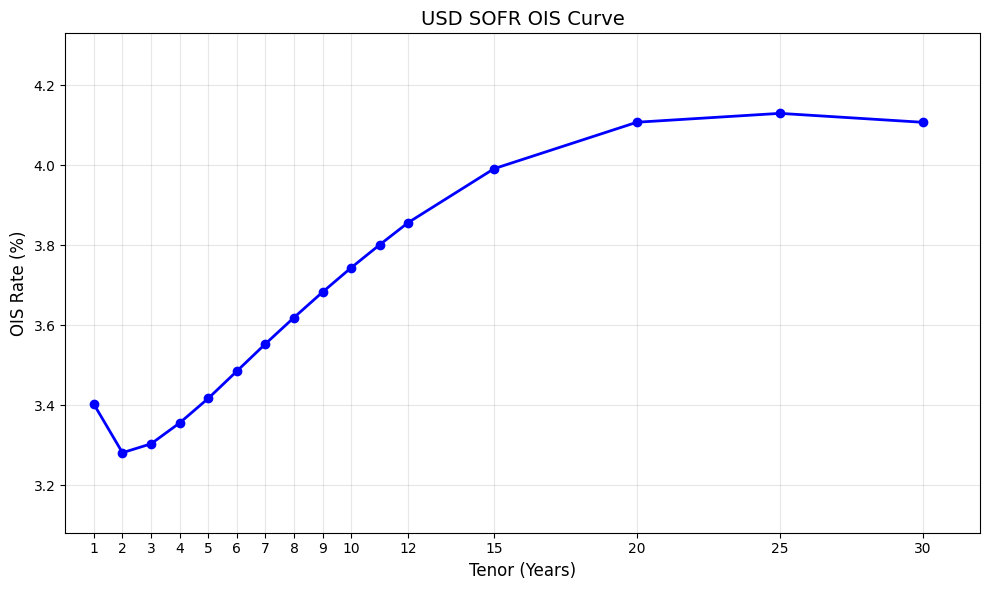

In [9]:
tenors = [int(col[4:]) for col in OIS.columns]
rates = OIS.iloc[0].values * 100

print(f'Tenors: {tenors}')
print(f'Rates (%): {[f"{r:.2f}" for r in rates]}')

plt.figure(figsize=(10, 6))
plt.plot(tenors, rates, 'b-o', linewidth=2, markersize=6)
plt.title('USD SOFR OIS Curve', fontsize=14)
plt.xlabel('Tenor (Years)', fontsize=12)
plt.ylabel('OIS Rate (%)', fontsize=12)

plt.xlim(0, 32)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

y_min = min(rates) - 0.2
y_max = max(rates) + 0.2
plt.ylim(y_min, y_max)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
print("First 5 OIS rates (decimal):")
for i in range(5):
    print(f"  {OIS.columns[i]}: {OIS.iloc[0, i]:.6f} ({OIS.iloc[0, i]*100:.3f}%)")

First 5 OIS rates (decimal):
  USSO1: 0.034032 (3.403%)
  USSO2: 0.032820 (3.282%)
  USSO3: 0.033041 (3.304%)
  USSO4: 0.033563 (3.356%)
  USSO5: 0.034176 (3.418%)


### 8.2 The Bootstrap Class

This class implements our bootstrapping algorithm:
1. Store instruments (swap rates) in a dictionary
2. Calculate discount factors using forward substitution
3. Convert to zero rates

In [11]:
class GetDiscFactors:
    """Bootstrap discount factors from swap rates."""

    def __init__(self):
        self.instr = {}        # populated using add_instr() method
        self.disc_factors = {}
        self.zero_rates = {}

    def add_instr(self, par, T, coup, price, freq=1):
        """Add an instrument to the curve.
        
        Args:
            par: Par value (typically 1 for swaps)
            T: Tenor in years
            coup: Coupon/rate (the OIS rate as decimal)
            price: Price (1 for par swaps)
            freq: Payment frequency (1 = annual)
        """
        self.instr[T] = (par, coup, price, freq)

    def sort_instr(self):
        """Return sorted list of tenors."""
        return sorted(self.instr.keys())

    def get_df(self):
        """Calculate and return discount factors."""
        self.__get_shortdated_df__()
        self.__get_longdated_df__()
        return [self.disc_factors[i] for i in self.sort_instr()]

    def __get_shortdated_df__(self):
        """Calculate discount factors for zero-coupon instruments (T < 1yr).
        
        For a zero-coupon instrument: df = 1 / (1 + yield × T)
        """
        for T in self.instr:
            (par, coup, price, freq) = self.instr[T]
            if coup == 0:
                self.disc_factors[T] = 1.0 / (1.0 + (1.0 - price) * T)

    def __get_longdated_df__(self):
        """Bootstrap discount factors for coupon-bearing instruments.
        
        Uses forward substitution: solve for df[n] using known df[1..n-1]
        """
        for T in self.sort_instr():
            (par, coup, price, freq) = self.instr[T]
            
            # Year 1 discount factor: df₁ = 1 / (1 + rate₁)
            self.disc_factors[1] = 1.0 / (1.0 + self.instr[1][1] * 365.0 / 360.0)
            
            if coup != 0:
                for i in range(2, T + 1):
                    sum_coup = 0
                    for k in range(1, i):
                        sum_coup += self.disc_factors[k] * self.instr[i][1] * 365.0 / 360.0
                    self.disc_factors[i] = (1 - sum_coup) / (1 + self.instr[i][1] * 365.0 / 360.0)

    def get_zero_rates(self):
        """Convert discount factors to zero rates.
        
        Zero rate = (1/df)^(1/T) - 1
        """
        self.get_df()
        for t, df in sorted(self.disc_factors.items()):
            self.zero_rates[t] = ((1.0 / df) ** (1 / t)) - 1.0
        return self.zero_rates

### 8.3 Loading Market Data

Now we add our Bloomberg OIS rates to the curve object.

In [12]:
curve = GetDiscFactors()

curve.add_instr(1, 0.25, 0., 0.9849)
curve.add_instr(1, 0.50, 0., 0.9837)

for year in range(1, 13):
    curve.add_instr(1, year, OIS.iloc[0, year - 1], 1)

curve.add_instr(1, 15, OIS.iloc[0, 12], 1)
curve.add_instr(1, 20, OIS.iloc[0, 13], 1)
curve.add_instr(1, 25, OIS.iloc[0, 14], 1)
curve.add_instr(1, 30, OIS.iloc[0, 15], 1)

print(f"Instruments added: {len(curve.instr)}")
print(f"Tenors: {curve.sort_instr()}")

Instruments added: 18
Tenors: [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30]


Bloomberg only quotes rates for certain tenors (1-12, 15, 20, 25, 30 years). We need rates for ALL years to bootstrap properly.

**Linear interpolation** fills the gaps. This is a simplification - in practice, more sophisticated interpolation methods (cubic splines, etc.) are used.

In [13]:
x = sorted(curve.instr.keys())
y = [curve.instr[i][1] for i in sorted(curve.instr.keys())]

missing_tenors = [13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29]

for tenor in missing_tenors:
    interpolated_rate = np.interp(tenor, x, y)
    curve.add_instr(1, tenor, interpolated_rate, 1)

print(f"Total instruments after interpolation: {len(curve.instr)}")
print(f"All tenors: {curve.sort_instr()}")

Total instruments after interpolation: 32
All tenors: [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [14]:
print("Instrument details (tenor: rate):")
for t in curve.sort_instr():
    rate = curve.instr[t][1]
    if rate > 0:
        print(f"  {t:5.2f}yr: {rate*100:.4f}%")
    else:
        print(f"  {t:5.2f}yr: zero-coupon (price={curve.instr[t][2]})")

Instrument details (tenor: rate):
   0.25yr: zero-coupon (price=0.9849)
   0.50yr: zero-coupon (price=0.9837)
   1.00yr: 3.4032%
   2.00yr: 3.2820%
   3.00yr: 3.3041%
   4.00yr: 3.3563%
   5.00yr: 3.4176%
   6.00yr: 3.4856%
   7.00yr: 3.5539%
   8.00yr: 3.6197%
   9.00yr: 3.6833%
  10.00yr: 3.7442%
  11.00yr: 3.8017%
  12.00yr: 3.8573%
  13.00yr: 3.9021%
  14.00yr: 3.9469%
  15.00yr: 3.9918%
  16.00yr: 4.0150%
  17.00yr: 4.0382%
  18.00yr: 4.0614%
  19.00yr: 4.0847%
  20.00yr: 4.1079%
  21.00yr: 4.1123%
  22.00yr: 4.1168%
  23.00yr: 4.1212%
  24.00yr: 4.1256%
  25.00yr: 4.1300%
  26.00yr: 4.1256%
  27.00yr: 4.1211%
  28.00yr: 4.1166%
  29.00yr: 4.1122%
  30.00yr: 4.1077%


### 8.4 Running the Bootstrap

Now the magic happens! We call `get_df()` which:
1. Calculates DF for short-dated instruments directly
2. Bootstraps DF for years 1, 2, 3... sequentially

**Interpreting the results:**
- `DF(1) = 0.967` means `$1` in 1 year is worth `$0.967` today
- `DF(10) = 0.686` means `$1` in 10 years is worth `$0.686` today
- `DF(30) = 0.287` means `$1` in 30 years is worth `$0.287` today

In [15]:
curve.get_df()

print("Discount Factors:")
for t in curve.sort_instr():
    print(f"  {t:5.2f}yr: {curve.disc_factors[t]:.6f}")

Discount Factors:
   0.25yr: 0.996239
   0.50yr: 0.991916
   1.00yr: 0.966646
   2.00yr: 0.936666
   3.00yr: 0.905892
   4.00yr: 0.874643
   5.00yr: 0.843137
   6.00yr: 0.811343
   7.00yr: 0.779558
   8.00yr: 0.748024
   9.00yr: 0.716826
  10.00yr: 0.686098
  11.00yr: 0.655992
  12.00yr: 0.626466
  13.00yr: 0.598448
  14.00yr: 0.570985
  15.00yr: 0.544091
  16.00yr: 0.520260
  17.00yr: 0.497130
  18.00yr: 0.474690
  19.00yr: 0.452928
  20.00yr: 0.431831
  21.00yr: 0.413959
  22.00yr: 0.396767
  23.00yr: 0.380230
  24.00yr: 0.364324
  25.00yr: 0.349027
  26.00yr: 0.335690
  27.00yr: 0.322917
  28.00yr: 0.310684
  29.00yr: 0.298968
  30.00yr: 0.287746


**Converting to Zero Rates**

Zero rate = $(1/DF)^{1/T} - 1$. Zero rates are easier to compare across maturities.

In [16]:
curve.get_zero_rates()

print("Zero Rates:")
for t in curve.sort_instr():
    print(f"  {t:5.2f}yr: {curve.zero_rates[t]*100:.4f}%")

Zero Rates:
   0.25yr: 1.5186%
   0.50yr: 1.6366%
   1.00yr: 3.4505%
   2.00yr: 3.3255%
   3.00yr: 3.3494%
   4.00yr: 3.4052%
   5.00yr: 3.4714%
   6.00yr: 3.5458%
   7.00yr: 3.6216%
   8.00yr: 3.6957%
   9.00yr: 3.7684%
  10.00yr: 3.8392%
  11.00yr: 3.9072%
  12.00yr: 3.9741%
  13.00yr: 4.0284%
  14.00yr: 4.0840%
  15.00yr: 4.1410%
  16.00yr: 4.1685%
  17.00yr: 4.1969%
  18.00yr: 4.2263%
  19.00yr: 4.2566%
  20.00yr: 4.2880%
  21.00yr: 4.2894%
  22.00yr: 4.2914%
  23.00yr: 4.2939%
  24.00yr: 4.2969%
  25.00yr: 4.3003%
  26.00yr: 4.2877%
  27.00yr: 4.2754%
  28.00yr: 4.2633%
  29.00yr: 4.2514%
  30.00yr: 4.2397%


### 8.6 Visualizing Results

The **discount curve** shows how discount factors decrease over time. This curve is the fundamental building block for pricing fixed income securities.

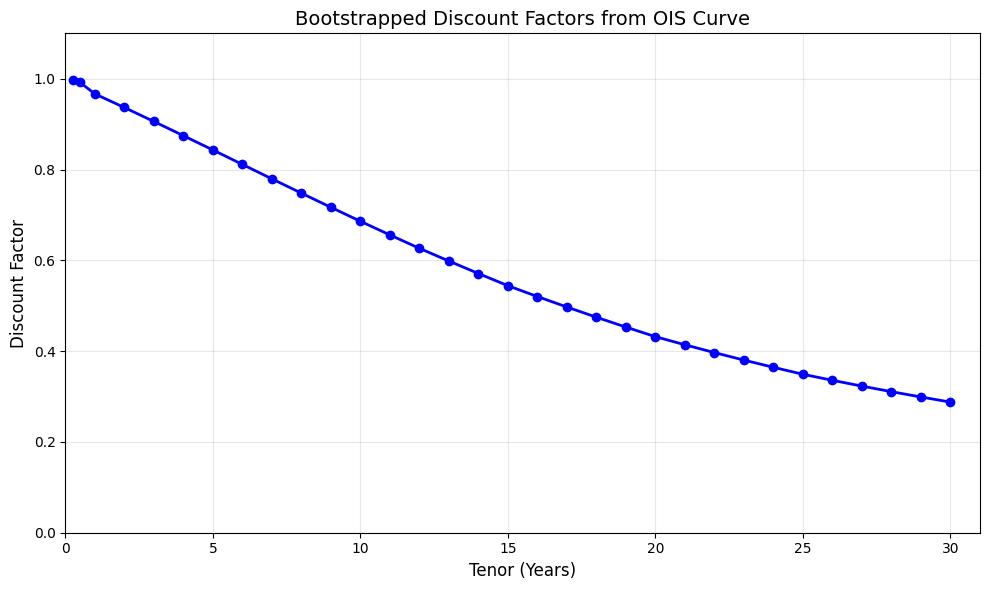

In [17]:
x = curve.sort_instr()
y = curve.get_df()

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-o', linewidth=2, markersize=6)
plt.title('Bootstrapped Discount Factors from OIS Curve', fontsize=14)
plt.xlabel('Tenor (Years)', fontsize=12)
plt.ylabel('Discount Factor', fontsize=12)

plt.xlim(0, 31)
plt.xticks(range(0, 32, 5))

plt.ylim(0, 1.1)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.5 Verification: Step-by-Step Calculation

Let's verify our implementation by manually calculating the first few discount factors and comparing to the class output.

In [18]:
r1 = OIS.iloc[0, 0]
r2 = OIS.iloc[0, 1]
r3 = OIS.iloc[0, 2]

print("=" * 60)
print("STEP-BY-STEP BOOTSTRAPPING EXAMPLE")
print("=" * 60)

print(f"\nInput swap rates:")
print(f"  r₁ (1-year): {r1*100:.4f}%")
print(f"  r₂ (2-year): {r2*100:.4f}%")
print(f"  r₃ (3-year): {r3*100:.4f}%")

dc = 365/360
print(f"\nDay count factor: 365/360 = {dc:.6f}")

print("\n" + "-" * 60)
print("STEP 1: Calculate DF₁ from 1-year swap")
print("-" * 60)
print(f"\nFormula: DF₁ = 1 / (1 + r₁ × 365/360)")
print(f"       = 1 / (1 + {r1:.6f} × {dc:.6f})")
print(f"       = 1 / (1 + {r1 * dc:.6f})")
print(f"       = 1 / {1 + r1 * dc:.6f}")
df1 = 1 / (1 + r1 * dc)
print(f"       = {df1:.6f}")

print("\n" + "-" * 60)
print("STEP 2: Calculate DF₂ from 2-year swap")
print("-" * 60)
print(f"\nFormula: DF₂ = (1 - r₂ × dc × DF₁) / (1 + r₂ × dc)")
numerator = 1 - r2 * dc * df1
denominator = 1 + r2 * dc
print(f"\nNumerator  = 1 - {r2:.6f} × {dc:.6f} × {df1:.6f}")
print(f"          = 1 - {r2 * dc * df1:.6f}")
print(f"          = {numerator:.6f}")
print(f"\nDenominator = 1 + {r2:.6f} × {dc:.6f}")
print(f"           = {denominator:.6f}")
df2 = numerator / denominator
print(f"\nDF₂ = {numerator:.6f} / {denominator:.6f} = {df2:.6f}")

print("\n" + "-" * 60)
print("STEP 3: Calculate DF₃ from 3-year swap")
print("-" * 60)
print(f"\nFormula: DF₃ = (1 - r₃ × dc × (DF₁ + DF₂)) / (1 + r₃ × dc)")
sum_df = df1 + df2
numerator = 1 - r3 * dc * sum_df
denominator = 1 + r3 * dc
print(f"\nSum of previous DFs = DF₁ + DF₂ = {df1:.6f} + {df2:.6f} = {sum_df:.6f}")
print(f"\nNumerator  = 1 - {r3:.6f} × {dc:.6f} × {sum_df:.6f}")
print(f"          = 1 - {r3 * dc * sum_df:.6f}")
print(f"          = {numerator:.6f}")
print(f"\nDenominator = 1 + {r3:.6f} × {dc:.6f}")
print(f"           = {denominator:.6f}")
df3 = numerator / denominator
print(f"\nDF₃ = {numerator:.6f} / {denominator:.6f} = {df3:.6f}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\n  Year 1: rate = {r1*100:.4f}% → DF = {df1:.6f}")
print(f"  Year 2: rate = {r2*100:.4f}% → DF = {df2:.6f}")
print(f"  Year 3: rate = {r3*100:.4f}% → DF = {df3:.6f}")
print(f"\nVerify against class: DF₁={curve.disc_factors[1]:.6f}, DF₂={curve.disc_factors[2]:.6f}, DF₃={curve.disc_factors[3]:.6f}")

STEP-BY-STEP BOOTSTRAPPING EXAMPLE

Input swap rates:
  r₁ (1-year): 3.4032%
  r₂ (2-year): 3.2820%
  r₃ (3-year): 3.3041%

Day count factor: 365/360 = 1.013889

------------------------------------------------------------
STEP 1: Calculate DF₁ from 1-year swap
------------------------------------------------------------

Formula: DF₁ = 1 / (1 + r₁ × 365/360)
       = 1 / (1 + 0.034032 × 1.013889)
       = 1 / (1 + 0.034505)
       = 1 / 1.034505
       = 0.966646

------------------------------------------------------------
STEP 2: Calculate DF₂ from 2-year swap
------------------------------------------------------------

Formula: DF₂ = (1 - r₂ × dc × DF₁) / (1 + r₂ × dc)

Numerator  = 1 - 0.032820 × 1.013889 × 0.966646
          = 1 - 0.032166
          = 0.967834

Denominator = 1 + 0.032820 × 1.013889
           = 1.033275

DF₂ = 0.967834 / 1.033275 = 0.936666

------------------------------------------------------------
STEP 3: Calculate DF₃ from 3-year swap
----------------------

In [19]:
df1 = (1 - 0.0) / (1 + OIS.iloc[0, 0] * 365 / 360)
df2 = (1 - df1 * OIS.iloc[0, 1] * 365 / 360) / (1 + OIS.iloc[0, 1] * 365 / 360)
df3 = (1 - (df1 + df2) * OIS.iloc[0, 2] * 365 / 360) / (1 + OIS.iloc[0, 2] * 365 / 360)
df4 = (1 - (df1 + df2 + df3) * OIS.iloc[0, 3] * 365 / 360) / (1 + OIS.iloc[0, 3] * 365 / 360)
df5 = (1 - (df1 + df2 + df3 + df4) * OIS.iloc[0, 4] * 365 / 360) / (1 + OIS.iloc[0, 4] * 365 / 360)

print("Manual calculation vs. GetDiscFactors class:")
print(f"  Year 1: {df1:.6f} vs {curve.disc_factors[1]:.6f}")
print(f"  Year 2: {df2:.6f} vs {curve.disc_factors[2]:.6f}")
print(f"  Year 3: {df3:.6f} vs {curve.disc_factors[3]:.6f}")
print(f"  Year 4: {df4:.6f} vs {curve.disc_factors[4]:.6f}")
print(f"  Year 5: {df5:.6f} vs {curve.disc_factors[5]:.6f}")

Manual calculation vs. GetDiscFactors class:
  Year 1: 0.966646 vs 0.966646
  Year 2: 0.936666 vs 0.936666
  Year 3: 0.905892 vs 0.905892
  Year 4: 0.874643 vs 0.874643
  Year 5: 0.843137 vs 0.843137


---

## References and Further Reading

### Academic References

- Hull, John C. *Options, Futures, and Other Derivatives*, 11th Edition. Pearson, 2022. — The classic derivatives textbook with comprehensive coverage of interest rate models.

- Tuckman, Bruce, and Angel Serrat. *Fixed Income Securities: Tools for Today's Markets*, 4th Edition. Wiley, 2022. — Deep dive into rates, term structure, and fixed income analytics.

### Implementation References

- Weiming, James Ma. *Mastering Python for Finance*, 2nd Edition. Packt Publishing, 2019. — Chapter 5 covers bootstrapping; the `GetDiscFactors` class in this notebook is adapted from code in this chapter.

- [Wikipedia: Bootstrapping (finance)](https://en.wikipedia.org/wiki/Bootstrapping_%28finance%29) — The forward substitution algorithm implemented here follows this reference.

### Bloomberg Documentation

- Bloomberg Terminal: `YCSW0490 Index CRVF <GO>` — USD SOFR OIS curve with rate type options
- Bloomberg Terminal: `SWDF <GO>` — Swap curve documentation
- Bloomberg Terminal: `FWCV <GO>` — Forward curve functions